# Search

Searching for products is one of the most important features of `eodag`. This page describes the different methods available to search for products and the parameters that these methods accept.

You will learn how to:
- [Pagination](#Pagination)  
- [Search methods](#Search-methods)  
- [SearchResult and EOProduct](#Searchresult-and-EOproduct)  
- [Search parameters](#Search-parameters)  
- [Guess a product type](#Guess-a-product-type)  
- [Fallback in case of error](#Fallback-in-case-of-error)

`eodag` is set here to search for *Sentinel 2 Level-1C* products with *PEPS*.

In [1]:
from eodag import EODataAccessGateway
from eodag import setup_logging
setup_logging(2)

dag = EODataAccessGateway()
dag.set_preferred_provider("peps")

2025-08-20 16:56:18,634 eodag.config                     [INFO    ] Loading user configuration from: /home/sylvain/.config/eodag/eodag.yml
2025-08-20 16:56:18,737 eodag.core                       [INFO    ] Locations configuration loaded from /home/sylvain/.config/eodag/locations.yml


A default set of search criteria is defined, the area of interest is in the South-West of France, and `count` is enabled.

In [2]:
default_search_criteria = {
    "productType": "S2_MSI_L1C",
    "start": "2021-03-01",
    "end": "2021-03-31",
    "geom": {"lonmin": 1, "latmin": 43, "lonmax": 2, "latmax": 44},
    "count": True
}

## Pagination

A [Google search](https://www.google.com/search?q=eodag) displays the first result page, which has 10 items (i.e. URLs). An action is required to get the next results, i.e. the second page, which would also contain 10 items. This process has the advantage of sending less data through the web, as a consequence the results are displayed faster. And after all, in most cases the URLs obtained from the first page are enough.

Pagination is what is described above. Most EO product providers operate this way, they return by default the first page result with a given number of items (i.e. products). Since pagination is ubiquitous among providers, it is built deep into `eodag` too and its search capabilities.

## Search methods

The three search methods introduced below accept pretty much the same parameters, which are described further down the page.

### [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search)

[search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) was the first search method implemented in `eodag`. It returns a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) that stores the products obtained from a given **page** and a given maximum **number of items per page**. The attribute [SearchResult.number_matched](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) optionally stores the **estimated** total number of products matching the search criteria.

By default, [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) **returns the products from the first page with a maximum of 20 products**. This means
that it is often expected to obtain a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) that contains 20 products and a much larger estimated
total number of products available.

<div class="alert alert-warning">

Warning

The [SearchResult.number_matched](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) attribute is the **estimated** total number of products matching the search criteria, since, unfortunately, all the providers do not return the **exact** total number.

</div>

Pagination can be controlled with two optional parameters: `page` and `items_per_page`.

In [3]:
products_first_page = dag.search(**default_search_criteria)

2025-08-20 16:56:26,081 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 16:56:26,083 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-08-20 16:56:37,692 eodag.core                       [INFO    ] Found 48 result(s) on provider 'peps'


In [4]:
print(f"Got a hand on {len(products_first_page)} products and an estimated total number of {products_first_page.number_matched} products available.")

Got a hand on 20 products and an estimated total number of 48 products available.


In [5]:
products_another_second_page = dag.search(page=2, items_per_page=10, **default_search_criteria)

2025-08-20 16:56:50,452 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 16:56:50,455 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=10&page=2
2025-08-20 16:56:51,668 eodag.core                       [INFO    ] Found 48 result(s) on provider 'peps'


In [6]:
print(f"Got a hand on {len(products_another_second_page)} products and an estimated total number of {products_another_second_page.number_matched} products available.")

Got a hand on 10 products and an estimated total number of 48 products available.


<div class="alert alert-warning">

Warning

To get all the products available, it would seem natural to set `items_per_page` to a very high value
(e.g. 10000). However, the providers usually have set a maximum number of products/items that can be
requested in a single query. If `items_per_page` is set to a value higher than this provider's limit, the
search may either return an empty [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) or fail and raise an error.

</div>

#### Error handling
The `raise_errors` parameter controls how errors raised internally during a search are propagated to the user. By default this parameter is set to `False`, which means that **errors are not raised**. Instead, errors are logged and a null result is returned (empty [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) and 0). The use of the `provider` kwarg and the error raised in the example below are explained in [the id and provider sub-section](#id-and-provider) and [the fallback section](#fallback-in-case-of-error) respectively.

In [7]:
bad_search_criteria = default_search_criteria.copy()
bad_search_criteria["start"] = "malformed_start_date"

In [8]:
products_first_page = dag.search(provider="peps", **bad_search_criteria)

2025-08-20 16:56:56,674 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 16:56:56,677 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=malformed_start_date&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-08-20 16:56:57,094 eodag.search.qssearch            [ERROR   ] Skipping error while searching for peps QueryStringSearch instance 
Traceback (most recent call last):
  File "/home/sylvain/workspace/eodag/eodag/plugins/search/qssearch.py", line 1278, in _request
    response.raise_for_status()
  File "/home/sylvain/workspace/eodag/.venv/lib/python3.9/site-packages/requests/models.py", line 1026, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 400 Client Error: Bad Request for url: https://pep

In [9]:
print(f"Got a hand on {len(products_first_page)} products and an estimated total number of {products_first_page.number_matched} products available.")

Got a hand on 0 products and an estimated total number of 0 products available.


Setting this parameter to `True` does propagate errors.

In [10]:
products_first_page = dag.search(**bad_search_criteria, raise_errors=True)

2025-08-20 16:57:55,903 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 16:57:55,906 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=malformed_start_date&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-08-20 16:57:56,279 eodag.search.qssearch            [ERROR   ] Skipping error while searching for peps QueryStringSearch instance 
Traceback (most recent call last):
  File "/home/sylvain/workspace/eodag/eodag/plugins/search/qssearch.py", line 1278, in _request
    response.raise_for_status()
  File "/home/sylvain/workspace/eodag/.venv/lib/python3.9/site-packages/requests/models.py", line 1026, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 400 Client Error: Bad Request for url: https://pep

RequestError: ('Skipping error while searching for peps QueryStringSearch instance', ' {"ErrorMessage":"Value for \\"startDate\\" must follow the pattern ^[0-9]{4}-[0-9]{2}-[0-9]{2}(T[0-9]{2}:[0-9]{2}:[0-9]{2}(\\\\.[0-9]+)?(|Z|[\\\\+\\\\-][0-9]{2}:[0-9]{2}))?$","ErrorCode":400}')

### [search_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_all)

[search_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_all) takes the pain away from thinking about pagination. It returns a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) that contains **all** the products matching the search criteria. It does so by iterating over the pages of a search result (with [search_iter_page()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_iter_page)) and gathering products. Compared to [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search):

* The attribute [SearchResult.number_matched](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) is `None`. The estimate of total number of products available isn't required here, since they all get collected anyway. This also spares some requests to be sent, since the estimate is usually obtained by sending an additional request.

* It tries to optimize the number of items/products requested per page. The limit of most providers has been configured in `eodag`, it is used if available (e.g. 500 products per page). If not available, a default value of 50 is used. An arbitrary value can also be used.

* It has no `raise_errors` parameter, errors are not caught.
  
* `count` is not available for this method, as it will be directly [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) length.

In [11]:
# remove count parameter from search criteria
default_search_criteria.pop("count", None)

all_products = dag.search_all(**default_search_criteria)

2025-08-20 17:00:30,926 eodag.core                       [INFO    ] Searching for all the products with provider peps and a maximum of 500 items per page.
2025-08-20 17:00:30,929 eodag.core                       [INFO    ] Iterate search over multiple pages: page #1
2025-08-20 17:00:30,930 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 17:00:30,932 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=500&page=1
2025-08-20 17:00:34,503 eodag.core                       [INFO    ] Found 48 result(s) on provider 'peps'


In [12]:
print(f"Got a hand on a total number of {len(all_products)} products.")

Got a hand on a total number of 48 products.


The parameter `items_per_page` controls the maximum number of products than can be retrieved at each iteration internally.

In [14]:
all_products = dag.search_all(**default_search_criteria, items_per_page=30)

2025-08-20 17:01:47,534 eodag.core                       [INFO    ] Searching for all the products with provider peps and a maximum of 30 items per page.
2025-08-20 17:01:47,537 eodag.core                       [INFO    ] Iterate search over multiple pages: page #1
2025-08-20 17:01:47,538 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 17:01:47,540 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=30&page=1
2025-08-20 17:01:50,066 eodag.core                       [INFO    ] Iterate search over multiple pages: page #2
2025-08-20 17:01:50,067 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 17:01:50,070 eodag.search.qssearch            [INFO    ] Sending search request: 

The logs show that two requests have been sent to gather all the products, while only one was required in the previous case where [search_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_all) used internally a limit higher than 48.

### [search_iter_page()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_iter_page)

[search_iter_page()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_iter_page) is a generator that returns a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) page per page. Compared to [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) and [search_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_all), it is certainly dedicated to be used by advanced users for some particular application.

As with [search_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_all), [search_iter_page()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_iter_page) doesn't have a `raise_errors` parameter, it doesn't catch errors. While [search_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_all) optimizes the number of items per page requested by iteration, [search_iter_page()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_iter_page) uses a default value of 20, which can be set to any arbitrary value.

In [15]:
all_results = []
for i, page_results in enumerate(dag.search_iter_page(**default_search_criteria, items_per_page=30)):
    print(f"Got a hand on {len(page_results)} products on page {i+1}")
    all_results.extend(page_results)

2025-08-20 17:02:33,764 eodag.core                       [INFO    ] Iterate search over multiple pages: page #1
2025-08-20 17:02:33,768 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 17:02:33,770 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=30&page=1
2025-08-20 17:02:36,347 eodag.core                       [INFO    ] Iterate search over multiple pages: page #2
2025-08-20 17:02:36,348 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 17:02:36,350 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.00

Got a hand on 30 products on page 1
Got a hand on 18 products on page 2


In [16]:
print(f"Got {len(all_products)} products after iterating over {i+1} pages.")

Got 48 products after iterating over 2 pages.


## [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) and [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct)

Each search method returns an instance of the [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) class. This object is a sequence that stores a number of [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) instances. A [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) supports some of the capabilities of a classic Python `list` object.

In [17]:
all_products[:2]

SearchResult([EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834, provider=peps),
              EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TCJ_20230602T033834, provider=peps)])

An [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) is the representation of an EO product for `eodag`, it stores enough information about how it was obtained (search criteria, provider) and about how to download itself. Most importantly it stores all the metadata that have been acquired by `eodag` during the search made

In [18]:
one_product = all_products[0]
one_product

EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834, provider=peps)

An [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) has the following attributes:

* `properties`: dictionary of the product's metadata
* `geometry`: the product's geometry as a `shapely.geometry` object
* `provider`: the provider used to obtain this product
* `product_type`: `eodag`'s identifier of its product type
* `search_kwargs`: a dictionary of the search criteria used to find the product.
* `remote_location`: the URL to the product's download link
* `location`: it is equal to `remote_location` before the product is downloaded. Once downloaded, it is updated to the absolute local path to the product.

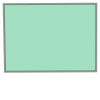

In [19]:
one_product.geometry

In [20]:
one_product.provider, one_product.product_type

('peps', 'S2_MSI_L1C')

In [21]:
one_product.search_kwargs

{'productType': 'S2_MSI_L1C',
 'startTimeFromAscendingNode': '2021-03-01',
 'completionTimeFromAscendingNode': '2021-03-31',
 'geometry': <POLYGON ((1 43, 1 44, 2 44, 2 43, 1 43))>}

In [22]:
one_product.remote_location, one_product.location

('https://peps.cnes.fr/resto/collections/S2ST/2d85d4c8-34c1-55dc-b43c-0ab0fe4c2b97/download',
 'https://peps.cnes.fr/resto/collections/S2ST/2d85d4c8-34c1-55dc-b43c-0ab0fe4c2b97/download')

In [23]:
one_product.properties.keys()

dict_keys(['abstract', 'instrument', 'platform', 'platformSerialIdentifier', 'processingLevel', 'keywords', 'sensorType', 'license', 'missionStartDate', 'title', '_id', 'productType', 'uid', 'keyword', 'resolution', 'organisationName', 'publicationDate', 'parentIdentifier', 'orbitNumber', 'orbitDirection', 'cloudCover', 'snowCover', 'creationDate', 'modificationDate', 'sensorMode', 'startTimeFromAscendingNode', 'completionTimeFromAscendingNode', 'id', 'quicklook', 'downloadLink', 'tileIdentifier', 'storageStatus', 'thumbnail', 'resourceSize', 'resourceChecksum', 'visible', 'newVersion', 'isNrt', 'realtime', 'relativeOrbitNumber', 'useDatalake', 'bucket', 'prefix', 's2TakeId', 'bareSoil', 'highProbaClouds', 'mediumProbaClouds', 'lowProbaClouds', 'snowIce', 'vegetation', 'water', 'isRefined', 'nrtResource', 'storage'])

An [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) has an [as_dict()](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct.as_dict) to convert it into a GeoJSON-like dictionary and a [from_geojson()](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct.from_geojson) method to create an [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) from a GeoJSON dictionary.

In [24]:
from eodag import EOProduct
product_geojson_structure = one_product.as_dict()
recreated_product = EOProduct.from_geojson(product_geojson_structure)
recreated_product

EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834, provider=peps)

Since [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct)s have a way to convert themselves to a GeoJSON dictionary, it is natural to be able to convert a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) object to a GeoJSON *FeatureCollection* ([as_geojson_object()](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult.as_geojson_object)). It is also possible to create a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) from a dictionary structured as a *FeatureCollection* with [from_geojson()](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult.from_geojson).

In [25]:
from eodag import SearchResult
feature_collection = all_products.as_geojson_object()
recreated_search_result = SearchResult.from_geojson(feature_collection)
recreated_search_result[:2]

SearchResult([EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834, provider=peps),
              EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TCJ_20230602T033834, provider=peps)])

You can also convert a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) object to other formats, like `shapely.geometry.GeometryCollection` ([as_shapely_geometry_object()](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult.as_shapely_geometry_object)), and `WKT` ([as_wkt_object()](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult.as_wkt_object)).

<div class="alert alert-info">

Note

[EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) and [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) objects have more methods and attributes than the ones listed aboved.
They are gradually introduced in the next pages of this user guide.

</div>

<div class="alert alert-info">

Note

When [eodag-cube](https://github.com/CS-SI/eodag-cube) is installed the [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) class used by `eodag` is the one provided by [eodag-cube](https://github.com/CS-SI/eodag-cube), which extends it with a few more capabilities, including a `get_data()` method to directly access the product's data.

</div>

## Search parameters

The search methods have exposed in their signature a common set of search parameters:

* `productType`
* `start` and `end`
* `geom`
* `locations`
* `count`

More parameters can be passed through *kwargs*, they are also described below.

Note that if you wish to know which parameters are available to use in a search, you may use the [queryables API](./4_queryables.ipynb).

### Product type

The `productType` parameter allows to specify which kind of product is searched for. It should be one of `eodag`'s product type ID, such as `S2_MSI_L1C`. They are discoverable with the method [list_product_types()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.list_product_types) or can be viewed [here](../../getting_started_guide/product_types.rst).

<div class="alert alert-warning">

Warning

The feature described below is intended for advanced users.

</div>

The product types exposed by `eodag` for a given provider are hard-coded in a configuration file. This means that a provider can add a new product type to its catalog, which would then not be listed in `eodag`'s configuration until it is updated. To cover this case, it has been made possible to search for a product type not referenced by `eodag`.

Internally, a generic product type has been created (`GENERIC_PRODUCT_TYPE`) to emulate a non-referenced product type. The parameters required to search for a non-referenced product type are saved in [eodag's internal provider configuration file](../../add_provider.rst#providers-pre-configuration). For example *creodias* is configured with this generic product type:

```
    GENERIC_PRODUCT_TYPE:
      productType: '{productType}'
      collection: '{collection}'
```

The above configuration indicates that for this provider a non-referenced product type can be searched for by passing the `productType` and `collection` parameters to a search method, e.g. `dag.search(collection="foo", productType="bar")`. **The values these parameters should take must be found by the user, eodag has just no clue about them**.

To provide a more concrete example, `eodag` allows to search for `S2_MSI_L1C` product types with *creodias*. This product type configuration is the following:

```
   S2_MSI_L1C:
      productType: L1C
      collection: Sentinel2
```

This means that `dag.search(productType="L1C", collection="Sentinel2")` should return the same products as `dag.search(productType="S2_MSI_L1C")`.

### Time period

`start` and `end` parameters are optional. They are used to search for products that have been sensed between these two times. Dates or datetimes must be passed as `strings` in UTC ISO8601 format (e.g. `yyyy-MM-dd`, `yyyy-MM-ddThh:mm:ss.SSSZ`). 

The `string` representation of dates will be interpreted as UTC datetime values, for instance, `2020-01-01` will be interpreted as `2020-01-01T00:00:00Z`. Consequently, when time is not explicitly specified:

- The start date will be inclusive, while the end date will be exclusive. In other words, results will include dates satisfying the condition: `start ≤ results_datetime < end`.

- To search for products within a single day, the start date can be specified as `2020-01-01` and the end date as `2020-01-02`.

### Area of interest

`eodag` provides multiple ways to define the area over which products should be searched for. The products returned are those that **intersect** with the area of interest, which means that their geometry can sometimes only partially overlap with the search geometry.

<div class="alert alert-warning">

Warning

`eodag` transforms the area of interest passed by the user (e.g. a `shapely` polygon) to a geometry representation accepted by the targeted provider (e.g. a WKT string). Providers can set a limit to the size of its query parameters. In the case of a very large and detailed geometry passed by the user, its representation might exceed the provider's limit (e.g. a very long WKT string). `eodag` tries internally to detect too long WKT strings, and simplifies them if so, by reducing the resolution of the input geometry iteratively. However, this algorithm doesn't enforce the output WKT string to be lower than a certain limit, `eodag` doesn't want to change too much the geometry passed by the user. As a consequence, the request sent might still contain a WKT string that is above the provider's limit (a *WARNING* is emitted), which would then end up in an error. In that case, it's the user's responsability to pass to `eodag` a simplified geometry, either by generating a convex hull or by splitting it (and executing multiple searches).

</div>

[folium](https://python-visualization.github.io/folium/) is used in this section to display the search area and the extent of the products found on an interactive map.

In [26]:
import folium

#### `geom` parameter

The first way to define an area of interest is to define the optinal `geom` parameter which accepts the following different inputs:

* a `Shapely` geometry object (any kind of geometry: point, line, polygon, multipolygon...)
* a *Well-Known Text* (WKT) string (any kind of geometry: point, line, polygon, multipolygon...)
* a bounding box as a dictionary with keys: `"lonmin"`, `"latmin"`, `"lonmax"`, `"latmax"`
* a bounding box as a list with elements provided in the order [lonmin, latmin, lonmax, latmax]

The coordinates must be provided in the **WGS84** projection (EPSG: 4326).

In [27]:
# Only a subset of the products is used not to overload the map
prods_to_map = all_products[::5]
print(f"{len(prods_to_map)} products are going to be mapped.")

10 products are going to be mapped.


In the previous searches made `geom` was defined as a bounding box expressed as a dictionary.

In [28]:
geometry = default_search_criteria["geom"]
geometry

{'lonmin': 1, 'latmin': 43, 'lonmax': 2, 'latmax': 44}

This is equivalent to:

In [29]:
geom = [1, 43, 2, 44]  # or geom = (1, 43, 1, 44)

In [30]:
from shapely.geometry import Polygon
geom = Polygon([[1, 43], [2, 43], [2, 44], [1, 44], [1, 43]])

In [31]:
geom = "POLYGON ((1 43, 2 43, 2 44, 1 44, 1 43))"  # WKT string

In [32]:
# Create a map zoomed over the search area
fmap = folium.Map([43.5, 1.5], zoom_start=7)
# Create a layer that represents the search area in red
folium.Rectangle(
    bounds=[[geometry["latmin"], geometry["lonmin"]], [geometry["latmax"], geometry["lonmax"]]],
    color="red",
    tooltip="Search extent"
).add_to(fmap)
# Create a layer that maps the products found
folium.GeoJson(
    data=prods_to_map,  # SearchResult has a __geo_interface__ interface used by folium to get its GeoJSON representation
    tooltip=folium.GeoJsonTooltip(fields=["title"])
).add_to(fmap)
fmap

### Locations search

Locations search is a powerful feature that greatly simplifies the setting of an area of interest.

When the `EODataAcessGateway` instance was created the logs showed that a *locations configuration* was automatically loaded by `eodag` from its local configuration directory. A *locations configuration* is a YAML file that contains a shapefile list associated to a name and an attribute. A minimal example of such a file is provided below:

```YAML
shapefiles:

  - name: continent
    path: /path/to/continents.shp
    attr: fullname
```

Where:
* `name` is the argument name that can be used in a [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) to refer to this specific location.
* `path` is the absolute path to the shapefile
* `attr` is the field of the shapefile that can be used to select features from it

For example, a *continents.shp* shapefile is set as a location in this file. The *path* entry is set to its absolute filepath, the *name* entry is set to `continent`. The shapefile contains continent's areas (polygons) and a field *fullname* (it may have other fields, they just won't be of any use here). The following search uses the geometry of the features of *continents.shp* that have *fullname* equal to `Europe`:

```python
products = dag.search(
    productType="S2_MSI_L1C",
    locations=dict(continent='Europe')
)
```

The location query (`continent="Europe"`) is passed as a dictionary to the `locations` parameter. It accepts [regular expressions](https://en.wikipedia.org/wiki/Regular_expression) which can come in handy when the query field has an underlying structure (e.g. see [this tutorial](../tutos/tuto_search_location_tile.ipynb) dedicated to search for products by tile(s)).

The locations configuration is stored in the `locations_config` attribute of the `EODataAcessGateway` once instantiated. `eodag` provides a default location which is a [Natural Earth Countries](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/) shapefile whose *ADM0_A3_US* field can be used to query specific countries by a short code such as *FRA* for *France* or *JPN* for *Japan*.

In [33]:
dag.locations_config

[{'name': 'country',
  'path': '/home/sylvain/.config/eodag/shp/ne_110m_admin_0_map_units.shp',
  'attr': 'ADM0_A3_US'},
 {'name': 's2_tile_centroid',
  'path': '/home/sylvain/.config/eodag/shp/sentinel2_tiling_grid_centroids.shp',
  'attr': 'tile_id'},
 {'name': 's2_tile',
  'path': '/home/sylvain/.config/eodag/shp/Features.shp',
  'attr': 'Name'}]

In [34]:
# Get the shapefile filepath and the field used as query parameter
countries_shpfile = dag.locations_config[0]["path"]
attr = dag.locations_config[0]["attr"]

# pyshp is imported to read the shapefile and display the values taken
# by the features for the field ADM0_A3_US.
import shapefile
with shapefile.Reader(countries_shpfile) as shp:
    shaperecs = shp.shapeRecords()
countries_adm0 = sorted(set(shprec.record[attr] for shprec in shaperecs))
print(f"Values taken by `country` ({attr}):\n\n{' '.join(countries_adm0)}")

Values taken by `country` (ADM0_A3_US):

AFG AGO ALB ARE ARG ARM ATA ATF AUS AUT AZE BDI BEL BEN BFA BGD BGR BHS BIH BLR BLZ BOL BRA BRN BTN BWA CAF CAN CHE CHL CHN CIV CMR COD COG COL CRI CUB CYP CZE DEU DJI DNK DOM DZA ECU EGY ERI ESP EST ETH FIN FJI FLK FRA GAB GBR GEO GHA GIN GMB GNB GNQ GRC GRL GTM GUY HND HRV HTI HUN IDN IND IRL IRN IRQ ISL ISR ITA JAM JOR JPN KAZ KEN KGZ KHM KOR KOS KWT LAO LBN LBR LBY LKA LSO LTU LUX LVA MAR MDA MDG MEX MKD MLI MMR MNE MNG MOZ MRT MWI MYS NAM NCL NER NGA NIC NLD NOR NPL NZL OMN PAK PAN PER PHL PNG POL PRI PRK PRT PRY PSX QAT ROU RUS RWA SAH SAU SDN SDS SEN SLB SLE SLV SOM SRB SUR SVK SVN SWE SWZ SYR TCD TGO THA TJK TKM TLS TTO TUN TUR TWN TZA UGA UKR URY USA UZB VEN VNM VUT YEM ZAF ZMB ZWE


A search will be made over Switzerland (CHE) and Belgium (BEL).

In [35]:
location_search_criteria = default_search_criteria.copy()
del location_search_criteria["geom"]
location_search_criteria["locations"] = dict(country="BEL|CHE")  # This regex means: BEL or CHE
location_search_criteria

{'productType': 'S2_MSI_L1C',
 'start': '2021-03-01',
 'end': '2021-03-31',
 'locations': {'country': 'BEL|CHE'}}

In [36]:
locations_products = dag.search(**location_search_criteria, items_per_page=50)

2025-08-20 17:03:58,958 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 17:03:58,960 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=MULTIPOLYGON (((6.1567 50.8037, 6.0431 50.1281, 5.7824 50.0903, 5.6741 49.5295, 4.7992 49.9854, 4.2860 49.9075, 3.5882 50.3790, 3.1233 50.7804, 2.6584 50.7968, 2.5136 51.1485, 3.3150 51.3458, 3.3150 51.3458, 3.3150 51.3458, 4.0471 51.2673, 4.9740 51.4750, 5.6070 51.0373, 6.1567 50.8037)), ((9.5942 47.5251, 9.6329 47.3476, 9.4800 47.1028, 9.9324 46.9207, 10.4427 46.8935, 10.3634 46.4836, 9.9228 46.3149, 9.1829 46.4402, 8.9663 46.0369, 8.4900 46.0052, 8.3166 46.1636, 7.7560 45.8245, 7.2739 45.7769, 6.8436 45.9911, 6.5001 46.4297, 6.0226 46.2730, 6.0374 46.7258, 6.7687 47.2877, 6.7366 47.5418, 7.1922 47.4498, 7.4668 47.6206, 8.3173 47.6136, 8.5226 47.8308, 9.5942 47.5251)))&productType=S2MSI

The results obtained are displayed on a map in addition to the countries of the default location shapefile.

In [37]:
# Create a map zoomed over the search area
fmap = folium.Map([48, 1.5], zoom_start=5)
# Create a layer that maps the countries in green
folium.GeoJson(
    data=shaperecs,
    tooltip=folium.GeoJsonTooltip(fields=["ADM0_A3_US"]),
    style_function=lambda x: {"color": "green"}
).add_to(fmap)
# Create a layer that maps the products found
folium.GeoJson(
    data=locations_products,
    tooltip=folium.GeoJsonTooltip(fields=["title"])
).add_to(fmap)
fmap

<div class="alert alert-info">

Note



</div>

#### Add locations search

Users are obsviously able to modify the location configuration file to add their own *locations* or to create their own YAML location configuration file. [EODataAccessGateway](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway) accepts the optional `locations_conf_path` parameter that can set to the path to another location configuration file. Alternatively, the environment variable `EODAG_LOCS_CFG_FILE` can also be set to define the path to another location configuration file (this has priority over the parameter value if passed too).

In [38]:
# dag = EODataAccessGateway(locations_conf_path="path/to/my_own_location_config.yaml")

#### Combined `geom` and locations search

`eodag` allows to combine a geometry search (e.g. a bounding box) with a location search. In that case the search area becomes the union of the two geometries found.

In [39]:
combined_search_criteria = default_search_criteria.copy()
combined_search_criteria["locations"] = location_search_criteria["locations"]
combined_search_criteria

{'productType': 'S2_MSI_L1C',
 'start': '2021-03-01',
 'end': '2021-03-31',
 'geom': {'lonmin': 1, 'latmin': 43, 'lonmax': 2, 'latmax': 44},
 'locations': {'country': 'BEL|CHE'}}

In [40]:
combined_products = dag.search(**combined_search_criteria, items_per_page=50)

2025-08-20 17:04:33,198 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 17:04:33,199 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=MULTIPOLYGON (((6.1567 50.8037, 6.0431 50.1281, 5.7824 50.0903, 5.6741 49.5295, 4.7992 49.9854, 4.2860 49.9075, 3.5882 50.3790, 3.1233 50.7804, 2.6584 50.7968, 2.5136 51.1485, 3.3150 51.3458, 3.3150 51.3458, 3.3150 51.3458, 4.0471 51.2673, 4.9740 51.4750, 5.6070 51.0373, 6.1567 50.8037)), ((9.5942 47.5251, 9.6329 47.3476, 9.4800 47.1028, 9.9324 46.9207, 10.4427 46.8935, 10.3634 46.4836, 9.9228 46.3149, 9.1829 46.4402, 8.9663 46.0369, 8.4900 46.0052, 8.3166 46.1636, 7.7560 45.8245, 7.2739 45.7769, 6.8436 45.9911, 6.5001 46.4297, 6.0226 46.2730, 6.0374 46.7258, 6.7687 47.2877, 6.7366 47.5418, 7.1922 47.4498, 7.4668 47.6206, 8.3173 47.6136, 8.5226 47.8308, 9.5942 47.5251)), ((1.0000 43.0000,

In [41]:
# Create a map zoomed over the search area
fmap = folium.Map([48, 1.5], zoom_start=5)
# Create a layer that represents the 'geom' search area in red
folium.Rectangle(
    bounds=[[geometry["latmin"], geometry["lonmin"]], [geometry["latmax"], geometry["lonmax"]]],
    color="red",
    tooltip="Search extent"
).add_to(fmap)
# Create a layer that maps the countries in green
folium.GeoJson(
    data=shaperecs,
    tooltip=folium.GeoJsonTooltip(fields=["ADM0_A3_US"]),
    style_function=lambda x: {"color": "green"}
).add_to(fmap)
# Create a layer that maps the products found
folium.GeoJson(
    data=combined_products,
    tooltip=folium.GeoJsonTooltip(fields=["title"])
).add_to(fmap)
fmap

### Count

The estimated total number of matching items can optionally be retrieved and stored in the [SearchResult.number_matched](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) attribute.
This is done by setting the search parameter `count=True`. If not set, *count* will be disabled (parameter default value is `False`) as this operation can cost extra time on some providers:

In [42]:
results_with_count = dag.search(count=True, **default_search_criteria)
print(f"number_matched: {results_with_count.number_matched}")

2025-08-20 17:04:54,814 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 17:04:54,817 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-08-20 17:04:56,851 eodag.core                       [INFO    ] Found 48 result(s) on provider 'peps'


number_matched: 48


In [43]:
results_with_count = dag.search(count=False, **default_search_criteria)
print(f"number_matched: {results_with_count.number_matched}")

2025-08-20 17:04:57,050 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 17:04:57,054 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1


number_matched: None


### `id` and `provider`

EO products have in their metadata an `id` field.

In [44]:
product_id = one_product.properties["id"]
product_id

'S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834'

This identifier, if known beforehand, can be used to search for this specific product by passing the `id` kwarg to the [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) method. This search by identifier can be optimized by including the appropriate `productType` in the kwargs. The `provider` kwarg can also be passed to specify among which provider's catalog the product should be searched for. If `provider` is not provided, `eodag` will iterate over all the providers until it finds the product targeted.

In [45]:
one_product_cop_dataspace = dag.search(id=product_id, productType="S2_MSI_L1C", provider="cop_dataspace")
one_product_cop_dataspace, one_product_cop_dataspace.number_matched

2025-08-20 17:05:06,376 eodag.core                       [INFO    ] Searching product with id 'S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834' on provider: cop_dataspace
2025-08-20 17:05:06,378 eodag.core                       [INFO    ] Iterate search over multiple pages: page #1
2025-08-20 17:05:06,380 eodag.core                       [INFO    ] Searching on provider cop_dataspace
2025-08-20 17:05:06,381 eodag.search.base                [INFO    ] cop_dataspace is configured with default sorting by 'startTimeFromAscendingNode' in ascending order
2025-08-20 17:05:06,385 eodag.search.qssearch            [INFO    ] Sending search request: https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20%27SENTINEL-2%27%20and%20Attributes/OData.CSC.StringAttribute/any%28att:att/Name%20eq%20%27productType%27%20and%20att/OData.CSC.StringAttribute/Value%20eq%20%27S2MSI1C%27%29%20and%20contains%28Name%2C%27S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_2

(SearchResult([EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834, provider=cop_dataspace)]),
 1)

### `sort_by`

EO products can be sorted by metadata that the provider used supports as sorting parameters (see the [available_sortables()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.available_sortables) method) in the wanted sorting order (`ASC`|`DESC`) by passing the `sort_by` kwarg. If `sort_by` is not passed but the provider has a default sorting parameter, the sort is realized with it. If the number of sorting parameters exceeds the maximum allowed for the provider or if the provider does not support the sorting feature or at least one sorting parameter, an error is returned.

In [46]:
sorted_by_start_date_in_asc_order_products = dag.search(
    provider="cop_dataspace",
    **default_search_criteria
)
sorted_by_start_date_in_desc_order_products = dag.search(
    provider="cop_dataspace",
    sort_by=[("startTimeFromAscendingNode", "DESC")],
    **default_search_criteria
)
print(
    "The start time of the first returned product is later than or equal to that "
    "of\nthe first returned product in the default search which sorts by start "
    "date\nin ascending order by default:",
    sorted_by_start_date_in_desc_order_products[0].properties['startTimeFromAscendingNode'] \
    >= \
    sorted_by_start_date_in_asc_order_products[0].properties['startTimeFromAscendingNode']
)

2025-08-20 17:05:37,521 eodag.core                       [INFO    ] Searching on provider cop_dataspace
2025-08-20 17:05:37,524 eodag.search.base                [INFO    ] cop_dataspace is configured with default sorting by 'startTimeFromAscendingNode' in ascending order
2025-08-20 17:05:37,529 eodag.search.qssearch            [INFO    ] Sending search request: https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20%27SENTINEL-2%27%20and%20OData.CSC.Intersects%28area=geography%27SRID=4326%3BPOLYGON%20%28%281.0000%2043.0000%2C%201.0000%2044.0000%2C%202.0000%2044.0000%2C%202.0000%2043.0000%2C%201.0000%2043.0000%29%29%27%29%20and%20Attributes/OData.CSC.StringAttribute/any%28att:att/Name%20eq%20%27productType%27%20and%20att/OData.CSC.StringAttribute/Value%20eq%20%27S2MSI1C%27%29%20and%20ContentDate/Start%20lt%202021-03-31T00:00:00.000Z%20and%20ContentDate/End%20gt%202021-03-01T00:00:00.000Z&$orderby=ContentDate/Start%20asc&$top=20&$skip=0&$expand=Attribu

The start time of the first returned product is later than or equal to that of
the first returned product in the default search which sorts by start date
in ascending order by default: True


### Extra query parameters

The search methods accept any additional query parameter passed as kwargs. Some of them may already be known to `eodag` and be converted in a correct way.

Providers generally accept many more request parameters than the basic ones provided by `eodag` by default (geometry and time period). Many of these parameters are actually known to `eodag` and configured internally (see [queryables](./4_queryables.ipynb)). They are just not exposed in the signature of the search methods, not to overload it, and also because these parameters are not necessarily share among all the providers.

### Cloud cover

A common parameter used when searching for EO products is the percentage of cloud cover. *PEPS* for instance accepts a `cloudCover` parameter. `eodag` knows how to transform it in a way that is adapted to *PEPS*.

In [47]:
products = dag.search(
    cloudCover=10,  # cloud cover Less than 10
    count=True,
    **default_search_criteria
)

2025-08-20 17:10:07,058 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 17:10:07,064 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?cloudCover=[0,10]&startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-08-20 17:10:08,217 eodag.core                       [INFO    ] Found 11 result(s) on provider 'peps'


It is possible to check that the search returned products than have a cloud cover less than 10%.

In [48]:
[p.properties["cloudCover"] for p in products]

[0,
 0.332726867187601,
 3.4506936264591905,
 0,
 0,
 0,
 0,
 0,
 0,
 7.062549162254081,
 2.06458837230135]

Having a closer look at the URL displayed in the logs above, it can be observed that `cloudCover=10` was actually converted by `eodag` to the query string `cloudCover=[0,10]`. This proves that `eodag` indeed knows about this parameter and how to adapt it for *PEPS*.

### Custom query parameters

<div class="alert alert-warning">

Warning

This feature is intended for advanced users.

</div>

Custom query parameters, unknown to `eodag`, are **propagated as is** until they are directly requested to the provider. This can be particularly useful when applying custom filters that are known to be accepted by the provider.

In [49]:
products = dag.search(
    random_parameter="random_value",
    count=True,
    **default_search_criteria
)

2025-08-20 17:10:14,794 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 17:10:14,799 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?random_parameter=random_value&startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-08-20 17:10:16,860 eodag.core                       [INFO    ] Found 48 result(s) on provider 'peps'


The logs above show that the random kwarg passed to the [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) method was indeed propagated to the request made to *PEPS*. It happens that *PEPS* ignores unsupported parameters and still returns products, another provider might just have sent an error.

## Guess a product type

`eodag` has an internal product type catalog which stores a number of metadata for each product type (see [this page](../../getting_started_guide/product_types.rst) for more information). It is actually possible to search for products by using some of these metadata. In that case, `eodag` will query its own catalog and use **the product type that best matches the query** among the available product types (i.e. all product types offered by providers where the necessary credentials are provided). The supported parameters are:

* `free_text`: *search applied to all of the following fields*
* `instrument` (e.g. *MSI*)
* `platform` (e.g. *SENTINEL2*)
* `platformSerialIdentifier` (e.g. *S2A*)
* `processingLevel` (e.g. *L1*)
* `sensorType` (e.g. *OPTICAL*)
* `keywords` (e.g. *SENTINEL2 L1C SAFE*), which is case insensitive and ignores `-` or `_` characters
* `abstract` (e.g. *"Level-1C product is composed of 100x100 km2"*), which is case insensitive
* `title` (e.g. *SENTINEL2 Level-1C*), which is case insensitive

For example, if we call the method with "Sentinel", all the product having one off their searchable (described just above) field matching "Sentinel" (case insensitive) will be returned.

In [50]:
# doing this
dag.guess_product_type("Sentinel")
# is equivalent as doing that
dag.guess_product_type(free_text="Sentinel")

['CLMS_CORINE',
 'CLMS_GLO_DMP_333M',
 'CLMS_GLO_FAPAR_333M',
 'CLMS_GLO_FCOVER_333M',
 'CLMS_GLO_GDMP_333M',
 'CLMS_GLO_LAI_333M',
 'EEA_DAILY_VI',
 'MO_GLOBAL_MULTIYEAR_WAV_001_032',
 'MO_SEAICE_GLO_SEAICE_L4_NRT_OBSERVATIONS_011_006',
 'MO_WAVE_GLO_PHY_SPC_FWK_L3_NRT_014_002',
 'MO_WAVE_GLO_PHY_SWH_L3_NRT_014_001',
 'MO_WAVE_GLO_PHY_SWH_L4_NRT_014_003',
 'S1_SAR_GRD',
 'S1_SAR_GRD_COG',
 'S1_SAR_OCN',
 'S1_SAR_RAW',
 'S1_SAR_SLC',
 'S2_MSI_L1C',
 'S2_MSI_L2A',
 'S2_MSI_L2A_COG',
 'S2_MSI_L2A_MAJA',
 'S2_MSI_L2B_MAJA_SNOW',
 'S2_MSI_L2B_MAJA_WATER',
 'S3_EFR',
 'S3_EFR_BC002',
 'S3_ERR',
 'S3_ERR_BC002',
 'S3_LAN',
 'S3_LAN_HY',
 'S3_LAN_LI',
 'S3_LAN_SI',
 'S3_OLCI_L2LFR',
 'S3_OLCI_L2LRR',
 'S3_OLCI_L2WFR',
 'S3_OLCI_L2WFR_BC003',
 'S3_OLCI_L2WRR',
 'S3_OLCI_L2WRR_BC003',
 'S3_RAC',
 'S3_SLSTR_L1RBT',
 'S3_SLSTR_L1RBT_BC003',
 'S3_SLSTR_L1RBT_BC004',
 'S3_SLSTR_L2',
 'S3_SLSTR_L2AOD',
 'S3_SLSTR_L2FRP',
 'S3_SLSTR_L2LST',
 'S3_SLSTR_L2WST',
 'S3_SLSTR_L2WST_BC003',
 'S3_SRA',
 'S3_

Now, let say we want only the product types whith the platform being "SENTINEL1":

In [51]:
dag.guess_product_type(platform="SENTINEL1")

['S1_SAR_GRD', 'S1_SAR_GRD_COG', 'S1_SAR_OCN', 'S1_SAR_RAW', 'S1_SAR_SLC']

By passing the following argument we can get all collections that contain the keyword collection2 and a keyword that starts with "LANDSAT".

In [52]:
dag.guess_product_type(keywords="LANDSAT* collection2")

['L8_OLI_TIRS_C1L1',
 'LANDSAT_C2L1',
 'LANDSAT_C2L2',
 'LANDSAT_C2L2ALB_BT',
 'LANDSAT_C2L2ALB_SR',
 'LANDSAT_C2L2ALB_ST',
 'LANDSAT_C2L2ALB_TA',
 'LANDSAT_C2L2_SR',
 'LANDSAT_C2L2_ST',
 'LANDSAT_ETM_C1',
 'LANDSAT_ETM_C2L1',
 'LANDSAT_ETM_C2L2',
 'LANDSAT_TM_C1',
 'LANDSAT_TM_C2L1',
 'LANDSAT_TM_C2L2']

In the previous request we made use of a free-text logical search query which supports:
- Logical operators: ``AND``, ``OR``, ``NOT``
- Grouping with parentheses: ``(``, ``)``
- Exact phrases in quotes: ``"foo bar"`` (case-insensitive substring match)
- Wildcards inside tokens:
  - ``*`` → matches zero or more characters
  - ``?`` → matches exactly one character
- Plain tokens without wildcards → matched as whole words (word boundary aware)
- Case-insensitive matching across all tokens and phrases

See the documentation of [compile_free_text_query()](../../api_reference/utils.rst#eodag.utils.free_text_search.compile_free_text_query) that is used in [guess_product_type()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.guess_product_type) method.

In [53]:
dag.guess_product_type(platform="LANDSAT OR SENTINEL1")

['CLMS_CORINE',
 'LANDSAT_C2L1',
 'LANDSAT_C2L2',
 'LANDSAT_C2L2ALB_BT',
 'LANDSAT_C2L2ALB_SR',
 'LANDSAT_C2L2ALB_ST',
 'LANDSAT_C2L2ALB_TA',
 'LANDSAT_C2L2_SR',
 'LANDSAT_C2L2_ST',
 'LANDSAT_ETM_C1',
 'LANDSAT_ETM_C2L1',
 'LANDSAT_ETM_C2L2',
 'LANDSAT_TM_C1',
 'LANDSAT_TM_C2L1',
 'LANDSAT_TM_C2L2',
 'S1_SAR_GRD',
 'S1_SAR_GRD_COG',
 'S1_SAR_OCN',
 'S1_SAR_RAW',
 'S1_SAR_SLC']

returns all product types where the platform is either LANDSAT or SENTINEL1.

In [54]:
dag.guess_product_type(keywords="(LANDSAT AND collection2) OR SAR")

['LANDSAT_C2L1',
 'LANDSAT_C2L2',
 'LANDSAT_C2L2ALB_BT',
 'LANDSAT_C2L2ALB_SR',
 'LANDSAT_C2L2ALB_ST',
 'LANDSAT_C2L2ALB_TA',
 'LANDSAT_C2L2_SR',
 'LANDSAT_C2L2_ST',
 'LANDSAT_ETM_C2L1',
 'LANDSAT_ETM_C2L2',
 'LANDSAT_TM_C2L1',
 'LANDSAT_TM_C2L2',
 'MO_WAVE_GLO_PHY_SPC_FWK_L3_NRT_014_002',
 'S1_SAR_GRD',
 'S1_SAR_GRD_COG',
 'S1_SAR_OCN',
 'S1_SAR_RAW',
 'S1_SAR_SLC']

returns all product types which contain either the keywords LANDSAT and collection2 or the keyword SAR.

In [55]:
dag.guess_product_type(platformSerialIdentifier="L?")

['CLMS_CORINE',
 'L8_OLI_TIRS_C1L1',
 'LANDSAT_C2L1',
 'LANDSAT_C2L2',
 'LANDSAT_C2L2ALB_BT',
 'LANDSAT_C2L2ALB_SR',
 'LANDSAT_C2L2ALB_ST',
 'LANDSAT_C2L2ALB_TA',
 'LANDSAT_C2L2_SR',
 'LANDSAT_C2L2_ST',
 'LANDSAT_ETM_C1',
 'LANDSAT_ETM_C2L1',
 'LANDSAT_ETM_C2L2',
 'LANDSAT_TM_C1',
 'LANDSAT_TM_C2L1',
 'LANDSAT_TM_C2L2',
 'S6_RADIO_OCCULTATION']

returns all product types where the platformSerialIdentifier is composed of 'L' and one other character.

In [56]:
dag.guess_product_type(platform="SENTINEL*")

['CLMS_CORINE',
 'CLMS_GLO_DMP_333M',
 'CLMS_GLO_FAPAR_333M',
 'CLMS_GLO_FCOVER_333M',
 'CLMS_GLO_GDMP_333M',
 'CLMS_GLO_LAI_333M',
 'EEA_DAILY_VI',
 'S1_SAR_GRD',
 'S1_SAR_GRD_COG',
 'S1_SAR_OCN',
 'S1_SAR_RAW',
 'S1_SAR_SLC',
 'S2_MSI_L1C',
 'S2_MSI_L2A',
 'S2_MSI_L2A_COG',
 'S2_MSI_L2A_MAJA',
 'S2_MSI_L2B_MAJA_SNOW',
 'S2_MSI_L2B_MAJA_WATER',
 'S3_EFR',
 'S3_EFR_BC002',
 'S3_ERR',
 'S3_ERR_BC002',
 'S3_LAN',
 'S3_LAN_HY',
 'S3_LAN_LI',
 'S3_LAN_SI',
 'S3_OLCI_L2LFR',
 'S3_OLCI_L2LRR',
 'S3_OLCI_L2WFR',
 'S3_OLCI_L2WFR_BC003',
 'S3_OLCI_L2WRR',
 'S3_OLCI_L2WRR_BC003',
 'S3_RAC',
 'S3_SLSTR_L1RBT',
 'S3_SLSTR_L1RBT_BC003',
 'S3_SLSTR_L1RBT_BC004',
 'S3_SLSTR_L2',
 'S3_SLSTR_L2AOD',
 'S3_SLSTR_L2FRP',
 'S3_SLSTR_L2LST',
 'S3_SLSTR_L2WST',
 'S3_SLSTR_L2WST_BC003',
 'S3_SRA',
 'S3_SRA_1A_BC004',
 'S3_SRA_1A_BC005',
 'S3_SRA_1B_BC004',
 'S3_SRA_1B_BC005',
 'S3_SRA_A',
 'S3_SRA_BS',
 'S3_SRA_BS_BC004',
 'S3_SRA_BS_BC005',
 'S3_SY_AOD',
 'S3_SY_SYN',
 'S3_SY_V10',
 'S3_SY_VG1',
 'S3_SY_VGP'

returns all product types where the platform starts with SENTINEL.

We can also pass several parameters at the same time, e.g.:

In [57]:
dag.guess_product_type(platform="LANDSAT", platformSerialIdentifier="L1")

['LANDSAT_C2L1',
 'CLMS_CORINE',
 'LANDSAT_C2L2',
 'LANDSAT_C2L2ALB_BT',
 'LANDSAT_C2L2ALB_SR',
 'LANDSAT_C2L2ALB_ST',
 'LANDSAT_C2L2ALB_TA',
 'LANDSAT_C2L2_SR',
 'LANDSAT_C2L2_ST',
 'LANDSAT_ETM_C1',
 'LANDSAT_ETM_C2L1',
 'LANDSAT_ETM_C2L2',
 'LANDSAT_TM_C1',
 'LANDSAT_TM_C2L1',
 'LANDSAT_TM_C2L2']

The product types in the result are ordered by how well they match the criteria. In the example above only the first product type (LANDSAT_C2L1) matches the second parameter (platformSerialIdentifier="L1"), all other product types only match the first criterion. Therefore, it is usually best to use the first product type in the list as it will be the one that fits best.

Per parameter, guesses are joined using a `UNION` by default (`intersect=False`). This can also be changed to an intersection:

In [58]:
dag.guess_product_type(platform="LANDSAT", platformSerialIdentifier="L1", intersect=True)

['LANDSAT_C2L1']

If a search is made without specifying `productType` but hints are passed using supported kwargs, `guess_product_type()` will internally be used to get the best matching product type.

In [59]:
guess_search_criteria = default_search_criteria.copy()
del guess_search_criteria["productType"]
guess_search_criteria.update(
    instrument="MSI",
    platform="SENTINEL2",
    platformSerialIdentifier="S2A",
    sensorType="OPTICAL",
)
guess_search_criteria

{'start': '2021-03-01',
 'end': '2021-03-31',
 'geom': {'lonmin': 1, 'latmin': 43, 'lonmax': 2, 'latmax': 44},
 'instrument': 'MSI',
 'platform': 'SENTINEL2',
 'platformSerialIdentifier': 'S2A',
 'sensorType': 'OPTICAL'}

In [60]:
dag.guess_product_type(**guess_search_criteria)[0]

'S2_MSI_L1C'

In [61]:
products = dag.search(count=True, **guess_search_criteria)

2025-08-20 17:11:16,280 eodag.core                       [INFO    ] Searching on provider peps
2025-08-20 17:11:16,282 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-08-20 17:11:18,349 eodag.core                       [INFO    ] Found 48 result(s) on provider 'peps'


`eodag` searches through its metadata catalog and checks which product type corresponds to the given parameters. There is a product type called `S2_MSI_L1C`, for the platform SENTINEL2 with the platformSerialIdentifiers S2A and S2B using the instrument MSI and the sensorType OPTICAL. Thus, all parameters of the product type `S2_MSI_L1C` are matching to the given search criteria and it is chosen to be internally used to search for products. If no product type is matching all the criteria, the one with the most matches is chosen, if several product types match all the given criteria, the first one is chosen.

In [62]:
products[0].product_type

'S2_MSI_L1C'

## Fallback in case of error

Usually, search is performed on the provider with the highest priority. If the request to this provider fails, i.e. if an error is returned (for example because the provider is currently unavailable) or if no results are returned, a request to the the provider with the next highest priority offering the desired product type will be attempted. In this case a warning message will be shown in the logs. If the request fails for all providers offering the desired product type, if at least one error occured during the fallback, an error will be raised, otherwise only an error message will be returned.

<pre>
2023-07-03 13:38:24,041 eodag.core  [INFO] (core) No result from provider 'peps' due to an error during search. Raise verbosity of log messages for details
2023-07-03 13:38:24,041 eodag.core  [WARNING] (core) No result could be obtained from provider peps, we will try to get the data from another provider
</pre>